In [8]:
import numpy as np
import scipy
from scipy import io as sio
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csgraph
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DenseDataLoader

from model import Net ######## change model

fc_sc_set = sio.loadmat('./../data/fc_and_sc_sets.mat')
# IDs = fc_sc_set['exist_both_fc_and_sc']
scs_desikan = sio.loadmat('./../data/scs_desikan.mat')
IDs = scs_desikan['subject_list']
correlations_desikan_old = sio.loadmat('./../data/correlations_desikan_old.mat')

SC_data,FC_data=[],[]
for i,id in enumerate(IDs):
    if id in scs_desikan['subject_list'] and id in correlations_desikan_old['subject_list']:#tfc_data['subject_list']:
        sc_pos = np.where(scs_desikan['subject_list']==id)[0][0]
        fc_pos = np.where(correlations_desikan_old['subject_list']==id)[0][0]
        SC_temp = scs_desikan['scs'][:,:,sc_pos].astype(np.float32)
        FC_temp = correlations_desikan_old['fcs'][:,:,fc_pos].astype(np.float32)
        SC_temp = (SC_temp + SC_temp.transpose()) / 2
        SC_data.append(SC_temp)
        FC_data.append(FC_temp)

SC_data = np.array(SC_data)
FC_data = np.array(FC_data)

subj = FC_data.shape[0]
rows = FC_data.shape[1]
cols = FC_data.shape[2]

#MinMax SC-Matrix Normalization
SC_data_norm = np.zeros([subj,rows,cols])

for i in np.arange(SC_data.shape[0]):
    scaler_sc = MinMaxScaler(feature_range=(0, 1))
    scaler_sc.fit(SC_data[i].flatten().reshape(-1,1))
    temp = scaler_sc.transform(SC_data[i].flatten().reshape(-1,1))
    SC_data_norm[i] = np.reshape(temp,(SC_data.shape[1],SC_data.shape[2]))


degree_sc =  np.zeros([subj,rows])
L_sc = np.zeros([subj,rows,cols])

for i in np.arange(subj):
    for j in np.arange(rows):
        degree_sc[i][j] = np.sum(SC_data_norm[i][j])
    # L_sc[i] = np.diag(degree_sc[i]) - SC_data_norm[i]
    L_sc[i] = csgraph.laplacian(SC_data_norm[i])


#eigendecomposition
Evec = np.zeros([subj,rows,cols])
Eval = np.zeros([subj,rows])
for i in np.arange(subj):
    w, u = np.linalg.eigh(L_sc[i])
    Evec[i] = u
    Eval[i] = w

k=87 ###### K VALUE SET HERE ######
Evec_k = Evec[:,:,:k]
Eval_k = Eval[:,:k]

SC = torch.from_numpy(SC_data_norm.astype(np.float32))
FC = torch.from_numpy(FC_data.astype(np.float32))
L = torch.from_numpy(L_sc.astype(np.float32))
EVAL = torch.from_numpy(Eval_k.astype(np.float32))
EVEC = torch.from_numpy(Evec_k.astype(np.float32))
print(SC.shape,FC.shape,L.shape,EVAL.shape,EVEC.shape)
def create_data_list(SC,FC,L,EVAL,EVEC):
    data_list = []
    for i in range(SC.shape[0]):
        x = SC[i]
        #consider only thode edges with correlation > 0.5
        edge_index = torch.from_numpy(np.indices(x.shape).reshape(2,-1))
        y = FC[i]
        data = Data(x=x, y=y, edge_index=edge_index,edge_weight=x.flatten(),laplacian=L[i],eigenvalues=EVAL[i],eigenvectors=EVEC[i])
        data_list.append(data)
    return data_list

conn_mat_list = create_data_list(SC,FC,L,EVAL,EVEC)
pygBatch = Batch.from_data_list(conn_mat_list).to('cuda')

print("Number of nodes in each brain graph:",pygBatch.num_nodes)
print("Number of SC-FC pairs:",pygBatch.num_graphs)



def batch_pearson_correlation(x, y):
    x = x.flatten()
    y = y.flatten()
    return np.abs(np.corrcoef(x.cpu().detach().numpy(),y.cpu().detach().numpy()))[1][0]

def mean_square_error(matrix1, matrix2):
    squared_diff = (matrix1.cpu().detach().numpy() - matrix2.squeeze(0).cpu().detach().numpy()) ** 2
    mse = np.mean(squared_diff)
    return mse

torch.Size([1058, 87, 87]) torch.Size([1058, 87, 87]) torch.Size([1058, 87, 87]) torch.Size([1058, 87]) torch.Size([1058, 87, 87])
Number of nodes in each brain graph: 92046
Number of SC-FC pairs: 1058


In [13]:
#load model 
def give_results(PATH,valindx):
    model = Net().to('cuda')
    # print(model)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    mse_ls = []
    pear_ls = []
    for ind in range(1058):
        placehold1 = FC[ind]
        placehold2 = model(conn_mat_list[ind].to('cuda'))
        mse_ls.append(mean_square_error(placehold1,placehold2))
        pear_ls.append(batch_pearson_correlation(placehold1,placehold2))
    mse_ls = np.array(mse_ls)[valindx]
    pear_ls = np.array(pear_ls)[valindx]
    print("Mean Squared Error:",np.mean(mse_ls),"+/-",np.std(mse_ls),"\nPearson Correlation:",np.mean(pear_ls),"+/-",np.std(pear_ls))
    return mse_ls,pear_ls

In [20]:
mse_all = []
pear_all = []

for i in range(5):
    PATH = f'../results/fold_{i+1}_model_concat.pt'#_mtdmlp
    valind = np.load(f'../results/fold_{i+1}_results_concat.npy',allow_pickle=True).item()['val_indx']#_mtdmlp
    mse,pear = give_results(PATH,valind)
    mse_all.append(mse[:211])
    pear_all.append(pear[:211])

Mean Squared Error: 0.022881089 +/- 0.014553674 
Pearson Correlation: 0.8303597617999939 +/- 0.040305621801370664
Mean Squared Error: 0.0197895 +/- 0.009316089 
Pearson Correlation: 0.8393691721217035 +/- 0.03900749348511708
Mean Squared Error: 0.024343373 +/- 0.015088056 
Pearson Correlation: 0.8278266076452654 +/- 0.0425581798016862
Mean Squared Error: 0.021151349 +/- 0.012149874 
Pearson Correlation: 0.8383193305722394 +/- 0.03968470044102789
Mean Squared Error: 0.022197995 +/- 0.013007184 
Pearson Correlation: 0.8309050076973606 +/- 0.03872860921328381


In [21]:
# 0.025933266 +/- 0.0121118035
# 0.7858365524740817 +/- 0.050655446860190204
# 0.02478461 +/- 0.01286263 
# 0.8000803337720692 +/- 0.04598469453545036
# 0.023922468 +/- 0.012581313 
# 0.8045106497759205 +/- 0.04718637083985416
# 0.022745596 +/- 0.010825694 
# 0.8063705990722845 +/- 0.04624980827768561
# 0.024150286 +/- 0.012479798 
# 0.7997667574312602 +/- 0.04587850623006658

# (0.7858365524740817+0.8000803337720692+0.8045106497759205+0.8063705990722845+0.7997667574312602)/5,(0.025933266+0.02478461+0.023922468+0.022745596+0.024150286)/5


In [23]:
# for i in range(5):
#     print(mse_all[i].shape)

(5, 211) (5, 211)


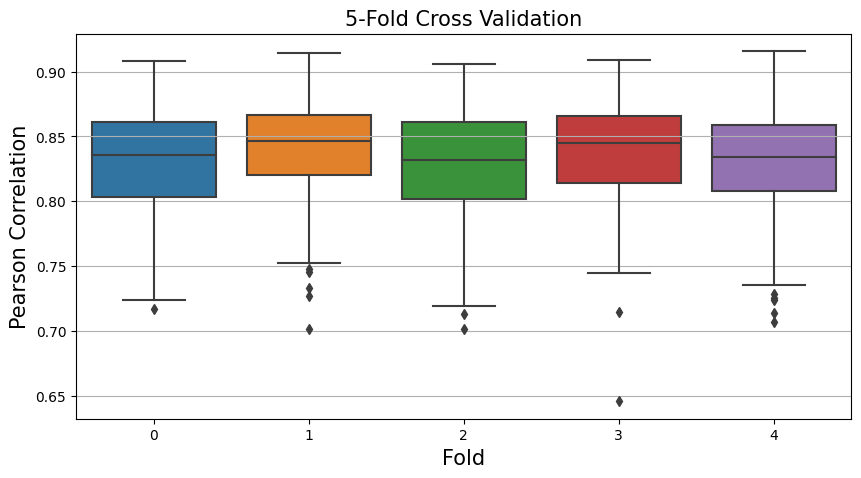

In [24]:
import pandas as pd 
import seaborn as sns
mse_all = np.array(mse_all)
pear_all = np.array(pear_all)
print(mse_all.shape,pear_all.shape)
#boxplot mse
df = pd.DataFrame(mse_all.T,columns=['Fold1','Fold2','Fold3','Fold4','Fold5'])

plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# sns.boxplot(data=df)
# plt.title("Mean Squared Error")
# plt.xlabel("Fold")
# plt.ylabel("MSE")
# plt.subplot(1,2,2)
sns.boxplot(data=pear_all.T)
plt.grid(axis='y')
plt.title("5-Fold Cross Validation",fontsize=15)
plt.xlabel("Fold",fontsize=15)
plt.ylabel("Pearson Correlation",fontsize=15)
plt.savefig('./../figure/5fold_concat.png',dpi=300,bbox_inches='tight',pad_inches=0.1,transparent=False,orientation='landscape')
plt.show()


In [25]:
pear_all.mean(axis=1)

array([0.83023131, 0.83940664, 0.82782068, 0.83831933, 0.83090501])

### diff_arr for 5 trials

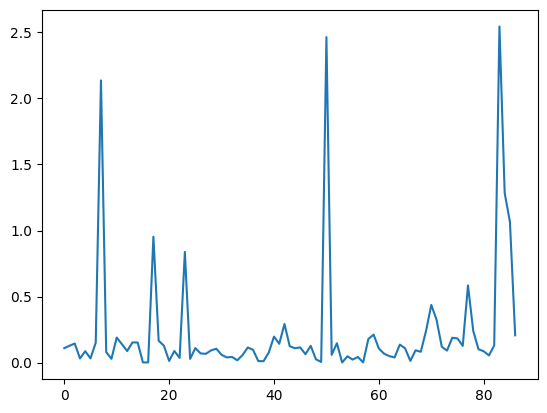

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
arr0 = np.array([8.6064e-02, 1.4732e-01, 2.6769e-01, 2.9408e-02, 1.0006e-01, 2.7363e-03,2.6802e-01, 2.7253e+00, 1.0000e-08, 9.4584e-03, 1.1868e-01, 1.3854e-01,1.0885e-01, 1.4683e-01, 1.0090e-01, 1.0000e-08, 1.0000e-08, 6.5913e-01,1.9807e-01, 1.1114e-01, 8.2884e-04, 1.0142e-01, 1.6112e-01, 1.1714e+00,3.0039e-02, 1.5555e-01, 7.6912e-02, 1.5170e-02, 6.9520e-02, 1.5742e-01,1.0000e-08, 1.0669e-03, 6.2545e-03, 1.0000e-08, 6.7640e-03, 3.9163e-02,4.1915e-01, 5.0242e-04, 1.0000e-08, 1.7468e-02, 1.9222e-01, 1.3811e-01,3.7689e-01, 1.0000e-08, 1.4219e-01, 9.3220e-02, 1.4776e-02, 1.6264e-01,4.3310e-04, 1.0000e-08, 1.2913e+00, 4.2592e-05, 1.1693e-01, 5.3973e-04,6.3374e-02, 4.1217e-02, 1.2938e-01, 2.1590e-03, 1.8383e-01, 2.6012e-01,8.7289e-02, 3.1438e-02, 1.7487e-02, 9.3452e-04, 1.2906e-01, 7.7674e-02,4.2984e-04, 1.9012e-01, 1.4383e-01, 1.8306e-01, 4.3181e-01, 2.3669e-01,2.9217e-02, 6.1376e-02, 1.2343e-01, 2.0553e-01, 1.3621e-01, 8.8453e-01,5.0165e-01, 1.3651e-01, 6.3614e-02, 1.3994e-02, 5.9520e-02, 2.5605e+00,1.3986e+00, 1.1304e+00, 2.9458e-01])
arr1 = np.array([1.1104e-01, 4.7457e-02, 1.2257e-01, 1.2271e-01, 5.3382e-02, 1.8262e-02,1.4531e-01, 2.2721e+00, 1.0000e-08, 6.3243e-02, 1.9303e-01, 1.1207e-01,1.4926e-01, 1.5730e-01, 3.1106e-01, 3.0208e-03, 8.1522e-06, 6.0845e-01,1.5853e-01, 1.4259e-01, 1.0000e-08, 1.2067e-01, 5.2153e-02, 1.2513e+00,1.0000e-08, 1.0849e-01, 1.1739e-01, 7.7662e-02, 1.4853e-01, 1.1817e-01,1.0000e-08, 1.0000e-08, 1.0000e-08, 5.1848e-04, 1.2743e-01, 3.7954e-02,2.5723e-02, 2.7665e-02, 1.9212e-03, 1.3676e-01, 3.5975e-01, 1.6664e-01,2.4191e-01, 6.1165e-01, 1.4697e-01, 1.4826e-01, 6.8234e-02, 1.5057e-01,1.0000e-08, 1.0000e-08, 2.9902e+00, 1.0000e-08, 1.2001e-01, 4.5764e-05,5.6069e-02, 4.0620e-02, 3.1402e-03, 2.1319e-03, 2.4760e-01, 1.3559e-01,4.8728e-02, 5.6748e-02, 4.9832e-02, 6.2156e-02, 9.9265e-02, 1.1070e-01,1.0000e-08, 5.0421e-02, 1.5261e-02, 1.8228e-01, 2.1553e-01, 3.5672e-01,9.4746e-02, 1.3216e-01, 1.0593e-01, 1.7247e-01, 1.1492e-01, 3.2070e-01,2.5173e-01, 9.2523e-02, 6.5740e-02, 1.0000e-08, 1.4367e-01, 3.4255e+00,1.9126e+00, 1.2118e+00, 3.0740e-01])
arr2 = np.array([9.6427e-02, 1.3907e-01, 8.0089e-02, 8.3351e-04, 5.7833e-02, 1.0000e-08,3.1169e-04, 2.9162e+00, 1.0000e-08, 4.8375e-03, 2.4289e-01, 1.0796e-01,5.8367e-02, 1.3755e-01, 1.0586e-01, 1.0000e-08, 1.0000e-08, 9.9656e-01,1.3906e-01, 8.4397e-02, 4.3098e-03, 6.6917e-02, 1.0000e-08, 7.2582e-01,9.0935e-04, 7.2776e-02, 3.2001e-02, 1.6788e-02, 5.5735e-02, 6.4813e-02,2.0628e-03, 8.4206e-04, 2.5068e-03, 1.0000e-08, 8.9018e-02, 2.1445e-01,1.0878e-02, 6.2529e-04, 2.1707e-03, 5.2876e-02, 1.6797e-01, 1.0407e-01,2.2474e-01, 1.5397e-03, 3.5618e-02, 1.0369e-01, 4.0090e-02, 4.0233e-02,1.0000e-08, 1.0000e-08, 3.6173e+00, 9.2588e-04, 1.4622e-01, 1.0000e-08,7.8216e-03, 1.0630e-02, 1.7848e-02, 1.6395e-03, 1.6098e-01, 1.4994e-01,8.5748e-02, 4.6421e-02, 1.5115e-02, 6.8588e-02, 2.3548e-02, 3.2291e-02,7.9224e-05, 8.6856e-02, 2.3549e-01, 3.3228e-01, 2.9493e-01, 1.3967e-01,1.5633e-01, 1.0998e-01, 2.3593e-01, 1.8667e-01, 1.5145e-01, 6.2947e-01,1.7998e-01, 5.7186e-02, 7.8054e-02, 2.9889e-02, 1.3599e-01, 2.9052e+00,1.9388e+00, 1.3989e+00, 1.5925e-01])
arr3 = np.array([1.0442e-01, 5.1905e-02, 1.7072e-01, 6.8739e-02, 8.5269e-02, 2.2176e-02,1.0000e-08, 2.4879e+00, 1.0000e-08, 8.7253e-03, 3.1789e-01, 1.3162e-01,2.9882e-02, 1.5784e-01, 7.5551e-02, 1.0732e-03, 1.0000e-08, 9.2186e-01,1.6524e-01, 1.8062e-01, 3.4139e-02, 1.5955e-01, 2.4339e-04, 5.4741e-01,1.0773e-01, 1.4300e-01, 1.1486e-01, 1.0909e-01, 9.3377e-02, 2.0529e-01,2.3050e-02, 1.0000e-08, 5.5971e-02, 3.4537e-03, 2.7323e-02, 1.5848e-01,8.2375e-02, 1.8939e-03, 1.0000e-08, 6.1230e-02, 2.1422e-01, 1.8514e-01,2.7354e-01, 1.0000e-08, 1.1935e-01, 1.0684e-01, 9.3916e-02, 2.0519e-01,1.0000e-08, 1.0000e-08, 2.8914e+00, 6.7198e-04, 1.6267e-01, 1.0000e-08,8.7112e-02, 1.0000e-08, 6.0951e-02, 1.0000e-08, 1.5584e-01, 2.5082e-01,1.1904e-01, 8.2848e-02, 2.4249e-03, 1.2453e-01, 1.2555e-01, 1.0000e-08,1.8802e-03, 1.7062e-02, 1.3313e-01, 5.6740e-02, 1.6238e-01, 1.8934e-01,1.1274e-01, 6.8298e-02, 1.8993e-01, 1.8218e-01, 1.3736e-01, 1.1590e+00,4.5534e-01, 5.7900e-02, 1.1771e-01, 5.7870e-03, 1.6586e-01, 3.4123e+00,8.6795e-01, 1.4694e+00, 2.5195e-01])
arr4 = np.array([1.2477e-01, 9.7319e-02, 1.5313e-01, 1.2876e-03, 5.2117e-02, 5.0758e-02,4.2733e-01, 1.4899e+00, 7.8807e-01, 4.2033e-02, 1.0946e-01, 1.6444e-01,6.8396e-02, 1.4036e-01, 4.2077e-01, 4.1691e-05, 1.0357e-02, 2.0703e+00,1.9370e-01, 6.0270e-02, 2.5472e-03, 4.5428e-02, 1.0000e-08, 1.6401e+00,2.3880e-02, 9.3099e-02, 5.3525e-02, 3.6253e-02, 1.3975e-01, 4.2585e-02,1.7256e-01, 1.3943e-01, 9.0627e-02, 1.0000e-08, 1.1859e-02, 6.5753e-02,5.4147e-02, 2.4463e-03, 6.5745e-03, 8.6799e-02, 2.2418e-01, 1.2208e-01,2.4921e-01, 9.1123e-04, 1.0446e-01, 1.3292e-01, 3.9103e-02, 1.1638e-01,2.9173e-02, 1.0000e-08, 1.0000e-08, 5.7749e-01, 1.0815e-01, 1.5494e-03,2.7356e-02, 9.2179e-04, 4.5630e-02, 2.1498e-03, 3.4831e-01, 1.8600e-01,1.7864e-01, 7.1803e-02, 2.0453e-02, 3.4640e-03, 1.6853e-01, 1.1919e-01,1.6311e-04, 7.1915e-04, 3.4270e-03, 1.5792e-01, 1.0388e+00, 5.2528e-01,1.3499e-01, 3.5367e-02, 2.5691e-01, 1.2721e-01, 1.0287e-01, 9.7717e-01,4.8745e-02, 8.6744e-02, 4.5617e-02, 1.3837e-01, 2.9093e-01, 7.8042e-01,5.3399e-01, 2.4210e-01, 9.8908e-02])
arr5 = np.array([1.1094e-01, 2.7752e-01, 1.2073e-01, 2.9737e-03, 1.7482e-01, 2.7891e-02,1.7034e-01, 1.9895e+00, 1.0000e-08, 1.2236e-02, 1.2697e-01, 1.5154e-01,8.1364e-02, 1.5896e-01, 5.4142e-02, 3.8203e-04, 1.0000e-08, 2.9415e-01,1.5171e-01, 1.4862e-01, 1.1012e-02, 1.3451e-01, 5.2340e-02, 5.1909e-01,9.8635e-02, 1.1881e-01, 1.2929e-01, 9.9953e-02, 1.0586e-01, 1.7851e-01,1.0000e-08, 3.3431e-04, 1.0156e-01, 3.3418e-04, 1.6325e-01, 1.4166e-01,1.2364e-01, 1.0000e-08, 1.6623e-03, 9.3699e-02, 3.0121e-01, 1.1801e-01,2.4992e-01, 1.0000e-08, 4.4997e-02, 1.0057e-01, 7.4249e-02, 1.9454e-01,1.0917e-03, 4.4366e-02, 3.3095e+00, 1.0000e-08, 1.4777e-01, 3.1442e-04,8.2567e-02, 3.8928e-04, 3.6251e-02, 3.7168e-04, 5.2602e-02, 1.8312e-01,1.0627e-01, 5.1849e-02, 1.5102e-01, 3.1717e-02, 1.9291e-02, 7.3637e-03,1.3234e-03, 1.7784e-01, 2.9997e-02, 3.3504e-01, 4.2097e-01, 2.9057e-01,1.6454e-01, 9.6229e-02, 1.5688e-01, 1.8997e-01, 1.2795e-01, 8.4227e-02,1.0016e-03, 1.0148e-01, 7.3451e-02, 1.0000e-08, 1.5941e-01, 3.2389e+00,1.3562e+00, 1.1554e+00, 1.7625e-01])
arr6 = np.array([1.0942e-01, 1.5615e-01, 1.0034e-01, 2.4444e-02, 8.3017e-02, 8.3487e-02,1.2960e-01, 2.6407e+00, 1.0000e-08, 5.4063e-02, 1.7859e-01, 1.5312e-01,5.9219e-02, 1.6434e-01, 2.0944e-01, 3.1190e-03, 1.1933e-04, 1.6289e+00,1.3762e-01, 1.5020e-01, 2.1474e-02, 2.2082e-02, 6.0550e-02, 8.0760e-01,1.0000e-08, 9.1243e-02, 3.3018e-02, 5.3341e-02, 7.6783e-02, 5.6725e-02,1.1580e-02, 1.0000e-08, 3.8380e-02, 1.0000e-08, 1.2310e-01, 9.4715e-02,2.8479e-02, 1.2036e-02, 1.0000e-08, 7.5246e-02, 2.3611e-01, 1.3467e-01,3.3367e-01, 4.0172e-01, 6.7985e-02, 1.1000e-01, 4.8822e-02, 9.7107e-02,1.2003e-01, 1.0000e-08, 3.4850e+00, 1.0000e-08, 1.0161e-01, 1.0000e-08,7.2715e-02, 4.6679e-02, 9.3148e-02, 1.0000e-08, 1.5692e-01, 2.4890e-01,2.2863e-01, 1.0027e-01, 1.8693e-01, 1.1663e-03, 5.2165e-02, 1.0000e-08,5.0387e-04, 1.6222e-01, 1.0000e-08, 2.1799e-01, 1.9070e-01, 1.6476e-01,1.7457e-01, 3.2881e-02, 2.4094e-01, 1.4004e-01, 1.3328e-01, 2.2946e-01,2.9605e-01, 1.7793e-01, 4.7667e-02, 1.0000e-08, 8.0271e-02, 1.9737e+00,2.1116e-01, 6.2048e-01, 5.6865e-02])
arr7 = np.array([1.3755e-01, 1.9873e-01, 9.9083e-02, 4.2725e-02, 1.0829e-01, 9.4335e-02,4.8576e-02, 1.4544e+00, 1.0000e-08, 2.7508e-03, 2.2417e-01, 1.5685e-01,9.9060e-02, 1.5520e-01, 2.6885e-02, 1.0000e-08, 2.3556e-04, 1.0016e+00,1.6221e-01, 1.9935e-01, 2.3781e-03, 7.9011e-02, 9.8421e-03, 4.1726e-01,3.0536e-03, 7.7681e-02, 7.5352e-03, 1.8700e-02, 6.1874e-02, 4.2559e-02,2.9687e-01, 2.4505e-01, 1.0109e-02, 9.7312e-02, 2.6805e-03, 1.4383e-01,2.2979e-02, 5.7198e-02, 2.8698e-02, 7.0677e-02, 6.1801e-02, 1.1281e-01,1.0000e-08, 8.4382e-06, 2.9053e-01, 1.3106e-01, 6.3757e-02, 6.4879e-02,3.4185e-02, 1.0000e-08, 1.5359e+00, 1.0000e-08, 1.4190e-01, 3.2356e-04,1.9179e-02, 1.3232e-03, 2.9371e-02, 8.5987e-04, 1.3085e-01, 1.8308e-01,8.1140e-02, 6.6844e-02, 3.6357e-03, 2.3558e-02, 1.4839e-01, 1.4471e-01,5.3459e-04, 2.8239e-02, 1.5793e-01, 4.3719e-01, 9.2854e-01, 7.9682e-01,1.0634e-01, 8.1684e-02, 1.5983e-01, 1.4589e-01, 1.1476e-01, 5.6053e-01,1.2442e-01, 7.8007e-02, 7.6765e-02, 9.6553e-02, 2.0075e-01, 1.6140e+00,1.2626e+00, 1.2192e+00, 1.9843e-01])
arr8 = np.array([1.1976e-01, 7.7833e-02, 2.0576e-01, 1.3898e-02, 4.6803e-02, 1.3088e-02,2.6389e-01, 1.8255e+00, 1.0000e-08, 3.7648e-05, 2.0518e-01, 1.4977e-01,1.0824e-01, 1.6730e-01, 1.4703e-01, 4.0380e-06, 1.0000e-08, 5.7022e-01,1.4801e-01, 1.0038e-01, 4.2293e-02, 6.4746e-02, 4.6903e-03, 7.1561e-01,1.3050e-02, 1.4156e-01, 5.3733e-02, 8.2095e-02, 8.0920e-02, 8.2115e-02,1.9393e-03, 1.0000e-08, 7.7268e-03, 6.6499e-02, 9.0722e-03, 2.0856e-01,3.1613e-02, 1.2882e-03, 9.5452e-04, 5.4263e-02, 1.8751e-01, 2.2058e-01,6.2625e-01, 1.0000e-08, 2.1677e-02, 9.4761e-02, 1.0799e-01, 1.1766e-01,5.5083e-02, 1.0000e-08, 2.1854e+00, 1.0000e-08, 1.0175e-01, 8.1875e-05,5.2607e-02, 8.0296e-03, 5.4311e-04, 1.0000e-08, 2.6710e-01, 3.0623e-01,8.4684e-02, 9.2333e-02, 2.5231e-02, 3.7501e-03, 4.4746e-01, 2.1454e-01,1.5479e-02, 7.9511e-02, 5.2408e-02, 3.3681e-01, 5.6615e-01, 4.2882e-01,9.1046e-02, 1.5186e-01, 2.1930e-01, 2.4735e-01, 1.3329e-01, 7.2517e-01,3.0178e-01, 1.3033e-01, 1.2935e-01, 1.0588e-01, 3.7411e-03, 2.1488e+00,1.7822e+00, 9.5506e-01, 2.4252e-01])
arr9 = np.array([9.0653e-02, 7.8640e-02, 1.1738e-01, 1.9427e-03, 9.4761e-02, 4.1541e-04,4.5313e-02, 1.5687e+00, 1.0000e-08, 8.3075e-02, 1.7505e-01, 1.2044e-01,1.0753e-01, 1.3769e-01, 6.3423e-02, 1.0000e-08, 1.0000e-08, 7.7668e-01,1.9703e-01, 9.8051e-02, 1.0000e-08, 7.7573e-02, 9.2606e-03, 5.8216e-01,6.3575e-05, 8.9540e-02, 7.0515e-02, 1.4968e-01, 8.6394e-02, 9.7535e-02,7.2616e-02, 5.3598e-04, 1.0869e-01, 1.0000e-08, 2.8290e-03, 3.3009e-02,1.6814e-01, 7.2225e-03, 5.6971e-02, 1.0275e-01, 1.8137e-02, 1.1453e-01,3.4326e-01, 2.2262e-01, 1.0847e-01, 1.2331e-01, 7.9306e-02, 1.1426e-01,1.9871e-03, 1.0000e-08, 3.3416e+00, 1.0000e-08, 3.1283e-01, 4.7391e-04,2.5987e-03, 7.4221e-02, 2.0339e-03, 1.0000e-08, 7.8434e-02, 2.0965e-01,3.7951e-02, 6.8037e-02, 1.0749e-02, 6.5933e-02, 1.4406e-01, 3.7323e-01,1.0486e-01, 1.3088e-01, 3.9662e-02, 1.6097e-01, 1.1496e-01, 1.1345e-01,1.3384e-01, 1.3228e-01, 1.8781e-01, 2.2723e-01, 1.0808e-01, 2.7500e-01,2.3502e-01, 9.0759e-02, 1.5265e-01, 1.4697e-01, 5.0731e-02, 3.3955e+00,1.5720e+00, 1.2443e+00, 2.7342e-01])
mean_arr = np.mean([arr0, arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, arr9], axis=0)
plt.plot(mean_arr)

In [ ]:
mean_arr

array([1.09104400e-01, 1.27194400e-01, 1.43749200e-01, 3.08961510e-02,
       8.56352000e-02, 3.13148720e-02, 1.49869070e-01, 2.13702000e+00,
       7.88070090e-02, 2.80459648e-02, 1.89191000e-01, 1.38635000e-01,
       8.70168000e-02, 1.52337000e-01, 1.51506100e-01, 7.64079900e-04,
       1.07201022e-03, 9.52785000e-01, 1.65118000e-01, 1.27561800e-01,
       1.18981960e-02, 8.71907000e-02, 3.50199410e-02, 8.37775000e-01,
       2.77360545e-02, 1.09174900e-01, 6.88779200e-02, 6.58732000e-02,
       9.18743000e-02, 1.04572200e-01, 5.80678130e-02, 3.87259290e-02,
       4.21825110e-02, 1.68117410e-02, 5.63325700e-02, 1.13757400e-01,
       9.67124000e-02, 1.10877620e-02, 9.89522500e-03, 7.51768000e-02,
       1.96310800e-01, 1.41664000e-01, 2.91939001e-01, 1.23844941e-01,
       1.08224700e-01, 1.14463100e-01, 6.30243000e-02, 1.26345900e-01,
       2.41982930e-02, 4.43660900e-03, 2.46476000e+00, 5.79130512e-02,
       1.45984000e-01, 3.32868900e-04, 4.71399300e-02, 2.24030880e-02,
      

### 1 non-linear MLP

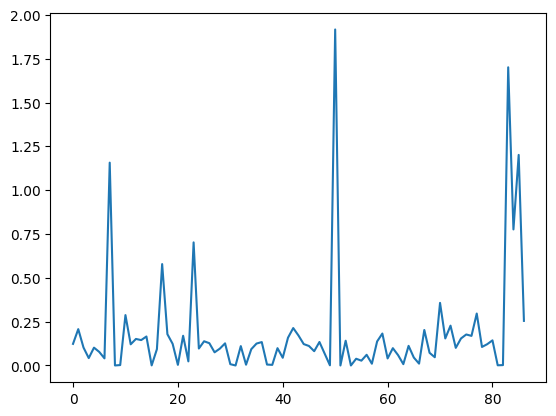

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
arr0 = np.array([1.1883e-01, 1.7002e-01, 1.0935e-01, 4.2105e-02, 1.0907e-01, 5.2177e-02,1.0000e-08, 1.1558e+00, 1.0000e-08, 4.1273e-03, 1.4658e-01, 1.4366e-01,1.2534e-01, 1.4468e-01, 8.2084e-02, 2.3373e-03, 4.8317e-04, 9.8458e-02,1.8453e-01, 9.5245e-02, 3.7050e-04, 1.3416e-01, 4.4659e-02, 1.0462e+00,8.1918e-02, 1.3626e-01, 1.4668e-01, 2.0378e-02, 1.0850e-01, 1.6437e-01,1.0000e-08, 1.0000e-08, 7.6595e-02, 1.0000e-08, 2.7383e-02, 5.0353e-03,1.0000e-08, 3.4854e-03, 1.4365e-02, 6.8202e-02, 3.7748e-02, 1.6343e-01,2.0584e-01, 2.6502e-01, 1.2702e-01, 1.1284e-01, 7.5539e-02, 1.3664e-01,5.8318e-02, 1.0000e-08, 2.5274e+00, 1.0000e-08, 1.4106e-01, 1.0000e-08,4.2483e-02, 5.4041e-02, 4.4710e-02, 1.6090e-03, 1.1774e-01, 2.3774e-01,3.5111e-02, 1.0732e-01, 1.0751e-01, 8.0543e-03, 1.2908e-01, 7.3433e-02,1.7611e-02, 2.1901e-01, 7.4370e-02, 3.4164e-02, 2.4252e-01, 4.4719e-02,2.4473e-01, 5.3879e-02, 1.4726e-01, 1.4864e-01, 1.6727e-01, 2.5397e-01,7.3694e-02, 1.1634e-01, 1.6641e-01, 1.0000e-08, 1.2850e-03, 1.6168e+00,4.3476e-01, 8.0331e-01, 2.4435e-01])
arr1 = np.array([1.3501e-01, 2.0277e-01, 1.1035e-01, 5.4869e-02, 1.1028e-01, 8.8817e-02,8.2137e-05, 8.1511e-01, 8.4757e-04, 1.0000e-08, 3.0929e-01, 1.1344e-01,1.3526e-01, 1.2995e-01, 1.1114e-02, 1.6176e-04, 1.4132e-01, 3.0534e-01,1.7149e-01, 1.6369e-01, 1.0000e-08, 1.9435e-01, 2.0777e-02, 7.9138e-01,3.3100e-02, 1.4074e-01, 1.6652e-01, 7.6525e-02, 1.0129e-01, 1.2123e-01,1.0000e-08, 1.0000e-08, 1.2716e-01, 1.0000e-08, 7.9486e-02, 1.8237e-01,3.2523e-02, 3.2299e-03, 1.0000e-08, 1.2061e-01, 1.2666e-04, 1.7901e-01,2.0757e-01, 1.3034e-01, 1.1261e-01, 1.1176e-01, 7.4284e-02, 1.4598e-01,7.2746e-02, 1.0000e-08, 1.9780e+00, 1.0000e-08, 1.3188e-01, 1.0000e-08,2.4823e-02, 3.6533e-02, 6.9329e-02, 9.2922e-04, 1.6077e-01, 1.7520e-01,4.4960e-02, 1.0504e-01, 3.8489e-02, 8.5353e-03, 1.2581e-01, 2.6741e-02,4.6360e-04, 1.5752e-01, 4.8123e-02, 9.2458e-02, 3.4652e-01, 1.6560e-01,1.9511e-01, 9.1455e-02, 1.5383e-01, 1.8146e-01, 1.6481e-01, 3.2289e-01,1.2457e-01, 1.1340e-01, 1.1862e-01, 9.6995e-05, 1.0000e-08, 1.7764e+00,1.0774e+00, 1.4241e+00, 2.9762e-01])
arr2 = np.array([1.5233e-01, 2.4279e-01, 6.6579e-02, 3.7159e-02, 8.6371e-02, 9.3509e-02,5.1790e-02, 1.1612e+00, 1.0000e-08, 7.8498e-04, 4.0777e-01, 1.2344e-01,1.4354e-01, 1.4986e-01, 1.4994e-01, 1.0000e-08, 2.7192e-01, 1.2222e-01,1.8596e-01, 1.2249e-01, 1.5310e-02, 2.7060e-01, 5.6197e-03, 5.6155e-01,7.3838e-02, 1.5842e-01, 1.2480e-01, 1.3021e-01, 1.0945e-01, 1.0035e-01,8.9774e-04, 1.0000e-08, 1.5050e-01, 2.0037e-02, 1.0495e-01, 2.0348e-01,1.0000e-08, 6.4188e-03, 1.8260e-03, 1.1336e-01, 6.0191e-02, 1.5078e-01,2.0411e-01, 1.6097e-03, 1.1479e-01, 1.1842e-01, 9.3099e-02, 1.3038e-01,1.0068e-01, 1.0000e-08, 2.4712e+00, 1.0000e-08, 1.5349e-01, 1.0000e-08,2.4333e-02, 2.3278e-02, 7.9889e-02, 4.4673e-02, 1.0312e-01, 1.6041e-01,8.1867e-03, 4.9707e-02, 3.6178e-02, 1.0874e-03, 5.8671e-02, 6.0307e-02,2.5248e-03, 2.6650e-01, 4.9676e-02, 8.1489e-02, 4.6927e-01, 2.5709e-01,2.4173e-01, 1.0802e-01, 1.6088e-01, 1.3846e-01, 1.8070e-01, 2.9181e-01,1.2086e-01, 1.3077e-01, 1.2307e-01, 2.8154e-04, 2.1959e-03, 1.6406e+00,8.0953e-01, 1.1873e+00, 2.9106e-01])
arr3 = np.array([1.0357e-01, 2.5800e-01, 1.3203e-01, 2.7309e-02, 9.8668e-02, 7.5038e-02,1.2301e-01, 1.9068e+00, 1.0000e-08, 1.0000e-08, 2.5173e-01, 1.0165e-01,1.0871e-01, 1.3739e-01, 4.0042e-01, 1.0000e-08, 1.9314e-02, 1.8161e+00,1.6211e-01, 1.1100e-01, 1.0000e-08, 1.4749e-01, 1.2389e-04, 7.0481e-01,1.3420e-01, 1.4968e-01, 1.1785e-01, 7.2928e-02, 9.8541e-02, 1.5915e-01,1.0000e-08, 1.0000e-08, 8.5744e-02, 1.0000e-08, 7.9122e-02, 5.4424e-04,6.3502e-01, 1.0000e-08, 1.0272e-03, 8.9562e-02, 9.4823e-02, 1.4733e-01,2.5444e-01, 1.0000e-08, 1.6430e-01, 9.7449e-02, 9.4355e-02, 1.5070e-01,3.6377e-02, 1.0000e-08, 9.6326e-01, 1.0000e-08, 1.4369e-01, 1.0000e-08,4.2022e-02, 1.1267e-02, 6.0048e-02, 1.0861e-03, 1.6574e-01, 1.8806e-01,9.8250e-02, 1.2295e-01, 4.8613e-02, 1.0000e-08, 1.2244e-01, 4.5194e-02,7.9158e-03, 2.4891e-01, 1.2203e-01, 2.6596e-02, 2.9221e-01, 1.7517e-01,2.2806e-01, 7.5875e-02, 1.0651e-01, 1.7182e-01, 1.4159e-01, 3.5732e-01,6.3131e-02, 1.1428e-01, 1.3015e-01, 2.3360e-03, 6.8293e-03, 1.6475e+00,4.6669e-01, 1.3526e+00, 2.0817e-01])
arr4 = np.array([1.0673e-01, 1.6308e-01, 9.3758e-02, 4.9371e-02, 1.0436e-01, 7.7555e-02,2.8215e-02, 7.4758e-01, 1.0000e-08, 6.5962e-03, 3.2183e-01, 1.2171e-01,2.4418e-01, 1.6222e-01, 1.8335e-01, 1.0000e-08, 3.2090e-02, 5.5059e-01,1.8891e-01, 1.2496e-01, 1.8118e-03, 1.0130e-01, 4.6333e-02, 4.0758e-01,1.6069e-01, 1.0583e-01, 7.9896e-02, 7.5591e-02, 6.2511e-02, 8.6315e-02,3.6372e-02, 1.0000e-08, 1.1237e-01, 2.0798e-03, 1.7408e-01, 2.3372e-01,1.0000e-08, 1.3148e-02, 6.6248e-05, 1.0188e-01, 2.6871e-02, 1.5110e-01,1.9573e-01, 4.5874e-01, 9.1720e-02, 1.1570e-01, 6.9899e-02, 1.0670e-01,6.8471e-02, 4.1927e-03, 1.6456e+00, 1.0000e-08, 1.3672e-01, 1.0000e-08,5.8156e-02, 1.2307e-02, 5.0510e-02, 1.9216e-03, 1.3846e-01, 1.4975e-01,1.4720e-02, 1.0857e-01, 6.3835e-02, 1.9901e-02, 1.2377e-01, 2.0370e-02,2.4049e-02, 1.2106e-01, 6.7094e-02, 1.5067e-04, 4.3519e-01, 1.2880e-01,2.2675e-01, 1.7351e-01, 2.0255e-01, 2.4414e-01, 1.8998e-01, 2.5616e-01,1.4624e-01, 1.3275e-01, 1.7828e-01, 2.8469e-03, 3.3319e-04, 1.8252e+00,1.0929e+00, 1.2398e+00, 2.3137e-01])
# arr5 = np.array()
# arr6 = np.array()
# arr7 = np.array()
# arr8 = np.array()
# arr9 = np.array()
mean_arr = np.mean([arr0, arr1, arr2, arr3, arr4], axis=0)#, arr5, arr6, arr7, arr8, arr9
plt.plot(mean_arr)

In [ ]:
mean_arr

array([1.23294000e-01, 2.07332000e-01, 1.02413400e-01, 4.21626000e-02,
       1.01749800e-01, 7.74192000e-02, 4.06194294e-02, 1.15729800e+00,
       1.69522000e-04, 2.30170000e-03, 2.87440000e-01, 1.20780000e-01,
       1.51406000e-01, 1.44820000e-01, 1.65381600e-01, 4.99818000e-04,
       9.30254340e-02, 5.78541600e-01, 1.78600000e-01, 1.23477000e-01,
       3.49846400e-03, 1.69580000e-01, 2.35025180e-02, 7.02304000e-01,
       9.67492000e-02, 1.38186000e-01, 1.27149200e-01, 7.51264000e-02,
       9.60584000e-02, 1.26283000e-01, 7.45395400e-03, 1.00000000e-08,
       1.10473800e-01, 4.42336600e-03, 9.30042000e-02, 1.25029908e-01,
       1.33508606e-01, 5.25642200e-03, 3.45689160e-03, 9.87228000e-02,
       4.39519320e-02, 1.58330000e-01, 2.13538000e-01, 1.71141942e-01,
       1.22088000e-01, 1.11233800e-01, 8.14352000e-02, 1.34080000e-01,
       6.73184000e-02, 8.38548000e-04, 1.91709200e+00, 1.00000000e-08,
       1.41368000e-01, 1.00000000e-08, 3.83634000e-02, 2.74852000e-02,
      

```
0
0.7814383382323006 0.7808143231143504 0.7802952387623268
0.024978107 0.024903966 0.02661876


1
0.7781838711252492 0.7777488612531942 0.7764546157000666
0.025779942 0.027131211 0.025886837


2
0.7832931729468104 0.759294574309854 0.7721959446790648
0.025441438 0.030171582 0.026017023

3
0.7782307363307317 0.767894619458034 0.7754533000703026
0.025774494 0.027263753 0.026139444
```